In [1]:
#imports
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, Flatten, Reshape, Dense, Conv2DTranspose
from keras import optimizers
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from matplotlib import image
import tensorflow as tf
from keras.callbacks import LambdaCallback
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/eva/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eva/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eva/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eva/.local/lib/python3.6/site-packages/tensorflow/python/framework/d

In [2]:
#load and look at data
train_path = '/home/eva/Desktop/courses/current-courses/DeepLearningCourse/Assignment3/WARWICK/Train/'
test_path = '/home/eva/Desktop/courses/current-courses/DeepLearningCourse/Assignment3/WARWICK/Test/'

def getWARWICKdata(path):
    all_files = listdir(path)
    labele = [fil for fil in all_files if 'label' in fil]
    slike = [fil for fil in all_files if 'image' in fil]
    labele.sort()
    slike.sort()
    imageData = list()
    Labels = list()
    for i in range(len(slike)):
        tmp = image.imread(path+slike[i])
        imageData.append(tmp[:,:,0:2]) #we skip the blue channel, since it is constantly 0.
        Labels.append(image.imread(path+labele[i]))
    
    return np.asarray(imageData), np.asarray(Labels)

x_train, y_train = getWARWICKdata(train_path)   #x_train.shape = (85, 128, 128, 3)
x_test, y_test = getWARWICKdata(test_path)

In [3]:
def plotWARWICKdata(datatoplot, GTlabelstoplot=None, labelstoplot=None, incols=True):
    s1 = datatoplot.shape[0]
    if datatoplot.shape[3]!=3:
        datatoplot = np.pad(datatoplot, [(0,0), (0,0), (0,0), (0,1)], mode='constant')
    s2 = 3 - (labelstoplot is None) - (GTlabelstoplot is None)
    if incols:
        fig, axes = plt.subplots(nrows=s1, ncols=s2, figsize=(s2*2.0, s1*2.0))
    else:
        fig, axes = plt.subplots(nrows=s2, ncols=s1, figsize=(s1*2.0, s2*2.0))
        axes = np.transpose(axes)
    for i in range(s1):
        ax = axes[i,0]
        ax.axis('off')
        ax.imshow(datatoplot[i,:])
    axes[0,0].set_title('raw data')
    
    if GTlabelstoplot is not None:
        for i in range(s1):
            ax = axes[i,1]
            #plt.subplot(s1, s2, s2*i+2)
            ax.axis('off')
            ax.imshow(GTlabelstoplot[i,:])
        axes[0,1].set_title('GT') 
    if labelstoplot is not None:
        for i in range(s1):
            ax = axes[i,2]
            #plt.subplot(s1, s2, s2*i+3)
            ax.axis('off')
            ax.imshow(labelstoplot[i,:])
        axes[0,2].set_title('result')
    plt.show()

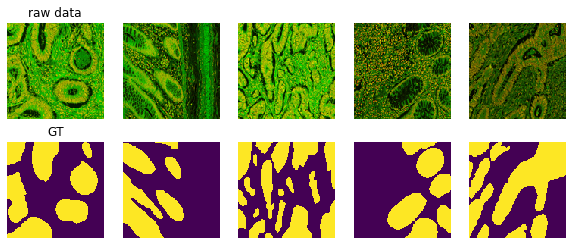

(85, 128, 128, 2) (85, 128, 128)


In [4]:
plotWARWICKdata(x_train[0:5,:], y_train[0:5,:],incols=False)
print(x_train.shape, y_train.shape)

In [5]:
def plot_history(history, what='loss', title=""):
    # Visualize loss history
    epoch_count = [i+1 for i in range(len(history[what]))]
    plt.plot(epoch_count, history[what], 'r--')
    if ('val_'+what) in history:
        plt.plot(epoch_count, history['val_'+what], 'b-')
        plt.legend(['Training '+what, 'Validation '+what])
    plt.xlabel('Epoch')
    plt.ylabel(what.capitalize())
    plt.title(title.capitalize())
    plt.show();

In [9]:
#define a fully convolutional neural network, with proper output size: 128 x 128
model = Sequential()
model.add(BatchNormalization(input_shape=(128, 128, 2)))
model.add(Conv2D(25, (3,3), padding='same', input_shape=(128, 128, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(120, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(120, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(2, (1,1), padding='same'))
model.add(Activation(lambda x: tf.nn.softmax(x, axis=-1)))
#model.add(Conv2D(1, (1,1), padding='same'))
#model.add(Activation('sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 128, 128, 2)       8         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 25)      475       
_________________________________________________________________
activation_17 (Activation)   (None, 128, 128, 25)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      14464     
_________________________________________________________________
activation_18 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 120)     69240     
__________

In [6]:
def my_loss(y_true, y_pred): #binary cross entropy
    numerator = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    denominator = tf.cast(tf.size(y_pred), tf.float32)
    return numerator / denominator

def dice(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(tf.abs(y_true * y_pred))
    # some implementations don't square y_pred
    denominator = tf.reduce_sum(tf.square(y_true) + tf.square(y_pred))
    
    return numerator / (denominator + tf.keras.backend.epsilon())

def dice_loss(y_true, y_pred):
    return 1-dice(y_true, y_pred)

In [32]:
#train it
epoh=15
minibatch = 64

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
      
y_train_onehot = np.stack((y_train, 1-y_train), axis=-1)

In [18]:
model.compile(optimizer=adam,
              loss=my_loss,
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_onehot, epochs=epoh, batch_size=minibatch, validation_split=0.2)

Train on 68 samples, validate on 17 samples
Epoch 1/30
68/68 [==============================] - 20s 300ms/step - loss: 0.5224 - acc: 0.4714 - val_loss: 0.3775 - val_acc: 0.6231
Epoch 2/30
68/68 [==============================] - 20s 298ms/step - loss: 0.3589 - acc: 0.6480 - val_loss: 0.3401 - val_acc: 0.6609
Epoch 3/30
68/68 [==============================] - 21s 308ms/step - loss: 0.3216 - acc: 0.6895 - val_loss: 0.3313 - val_acc: 0.6704
Epoch 4/30
68/68 [==============================] - 21s 307ms/step - loss: 0.3243 - acc: 0.6841 - val_loss: 0.2971 - val_acc: 0.7038
Epoch 5/30
68/68 [==============================] - 22s 316ms/step - loss: 0.2946 - acc: 0.7106 - val_loss: 0.3096 - val_acc: 0.6910
Epoch 6/30
68/68 [==============================] - 22s 322ms/step - loss: 0.2903 - acc: 0.7123 - val_loss: 0.3076 - val_acc: 0.6931
Epoch 7/30
68/68 [==============================] - 21s 315ms/step - loss: 0.2888 - acc: 0.7139 - val_loss: 0.2863 - val_acc: 0.7156
Epoch 8/30
68/68 [=======

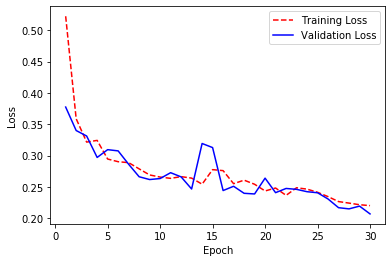

In [34]:
plot_history(hist.history)

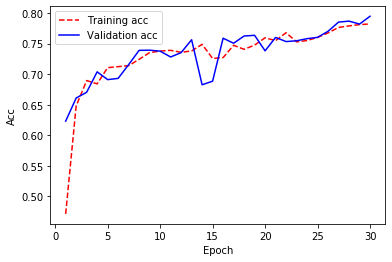

In [37]:
plot_history(hist.history, what='acc')

In [25]:
rezultati = model.predict(x_test[0:10,:])
rezultati_klasa = model.predict_classes(x_test[0:10,:])

In [27]:
print(rezultati.shape, rezultati_klasa.shape)

(10, 128, 128, 2) (10, 128, 128)


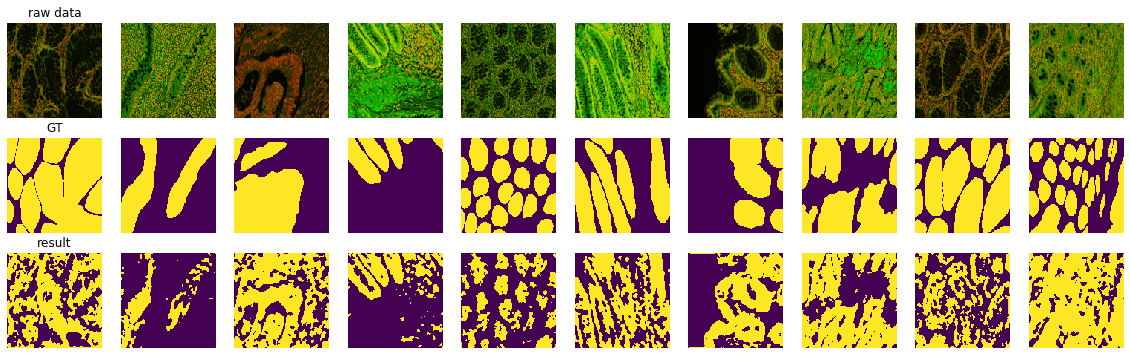

In [29]:
plotWARWICKdata(x_test[0:10,:], y_test[0:10,:], 1-rezultati_klasa, incols=False)

In [43]:
model.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy', dice])
hist2 = model.fit(x_train, y_train_onehot, epochs=30, batch_size=minibatch, validation_split=0.2)


Train on 68 samples, validate on 17 samples
Epoch 1/30
68/68 [==============================] - 21s 304ms/step - loss: 0.7772 - acc: 0.2197 - dice: 0.2228 - val_loss: 0.7018 - val_acc: 0.2970 - val_dice: 0.2982
Epoch 2/30
68/68 [==============================] - 21s 306ms/step - loss: 0.7281 - acc: 0.2691 - dice: 0.2719 - val_loss: 0.6728 - val_acc: 0.3261 - val_dice: 0.3272
Epoch 3/30
68/68 [==============================] - 22s 322ms/step - loss: 0.6857 - acc: 0.3109 - dice: 0.3143 - val_loss: 0.6474 - val_acc: 0.3515 - val_dice: 0.3526
Epoch 4/30
68/68 [==============================] - 22s 318ms/step - loss: 0.6579 - acc: 0.3381 - dice: 0.3421 - val_loss: 0.6219 - val_acc: 0.3769 - val_dice: 0.3781
Epoch 5/30
68/68 [==============================] - 22s 324ms/step - loss: 0.6361 - acc: 0.3590 - dice: 0.3639 - val_loss: 0.5994 - val_acc: 0.3991 - val_dice: 0.4006
Epoch 6/30
68/68 [==============================] - 22s 325ms/step - loss: 0.6075 - acc: 0.3838 - dice: 0.3925 - val_loss

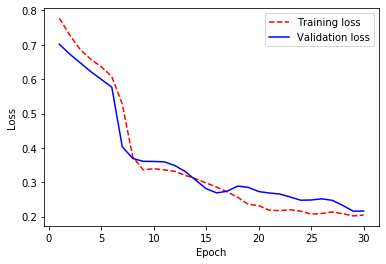

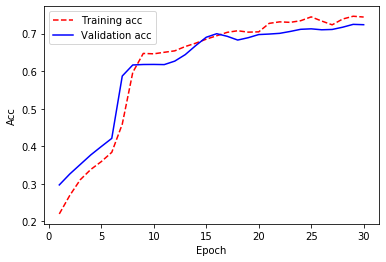

In [45]:
plot_history(hist2.history)
plot_history(hist2.history, what='acc')

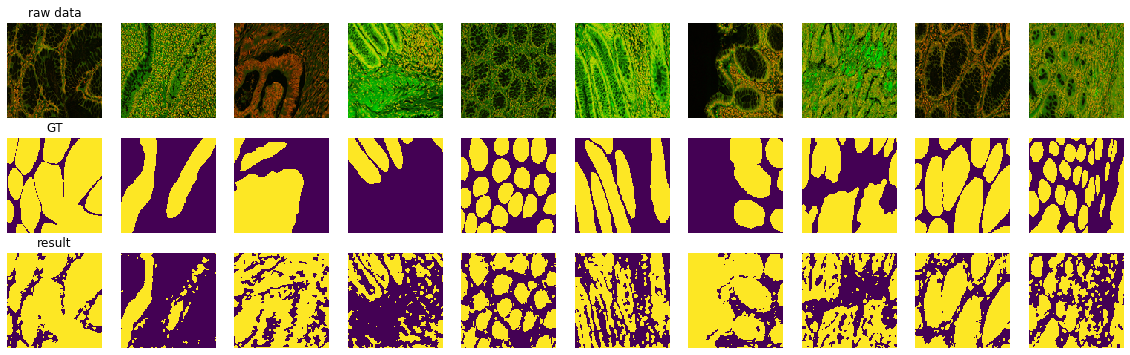

In [47]:
rezultati_klasa = model.predict_classes(x_test[0:10,:])
plotWARWICKdata(x_test[0:10,:], y_test[0:10,:], 1-rezultati_klasa, incols=False)

In [48]:
#now let's try with only 1-channel output, using sigmoid.
model = Sequential()
model.add(BatchNormalization(input_shape=(128, 128, 2)))
model.add(Conv2D(25, (3,3), padding='same', input_shape=(128, 128, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(120, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(120, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Conv2D(2, (1,1), padding='same'))
#model.add(Activation(lambda x: tf.nn.softmax(x, axis=-1)))
model.add(Conv2D(1, (1,1), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 128, 128, 2)       8         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 25)      475       
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 25)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      14464     
_________________________________________________________________
activation_23 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 120)     69240     
__________

In [53]:
y_train_expanded = np.expand_dims(y_train, axis=-1)

model.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])
hist_sigmoid = model.fit(x_train, y_train_expanded, epochs=30, batch_size=minibatch, validation_split=0.2)


Train on 68 samples, validate on 17 samples
Epoch 1/30
68/68 [==============================] - 21s 309ms/step - loss: 0.4505 - acc: 0.4458 - val_loss: 0.3101 - val_acc: 0.6769
Epoch 2/30
68/68 [==============================] - 21s 302ms/step - loss: 0.3187 - acc: 0.6388 - val_loss: 0.3511 - val_acc: 0.6187
Epoch 3/30
68/68 [==============================] - 21s 311ms/step - loss: 0.3121 - acc: 0.6239 - val_loss: 0.2609 - val_acc: 0.6988
Epoch 4/30
68/68 [==============================] - 21s 316ms/step - loss: 0.2883 - acc: 0.6859 - val_loss: 0.2624 - val_acc: 0.7066
Epoch 5/30
68/68 [==============================] - 23s 336ms/step - loss: 0.2858 - acc: 0.6653 - val_loss: 0.2299 - val_acc: 0.7162
Epoch 6/30
68/68 [==============================] - 21s 314ms/step - loss: 0.2635 - acc: 0.6826 - val_loss: 0.2056 - val_acc: 0.7004
Epoch 7/30
68/68 [==============================] - 22s 323ms/step - loss: 0.2417 - acc: 0.7039 - val_loss: 0.2119 - val_acc: 0.6658
Epoch 8/30
68/68 [=======

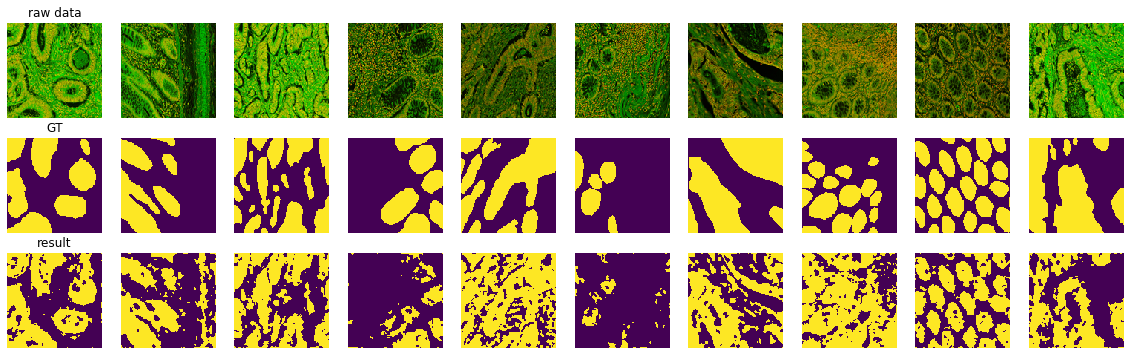

In [58]:
rezultati_klasa = model.predict_classes(x_train[0:10,:])
plotWARWICKdata(x_train[0:10,:], y_train[0:10,:], np.squeeze(rezultati_klasa), incols=False)


Test set evaluation 
Avg loss:  0.42090489765008293 , avg acc:  0.5247021834055583 , avg Dice:  0.5790951023499171


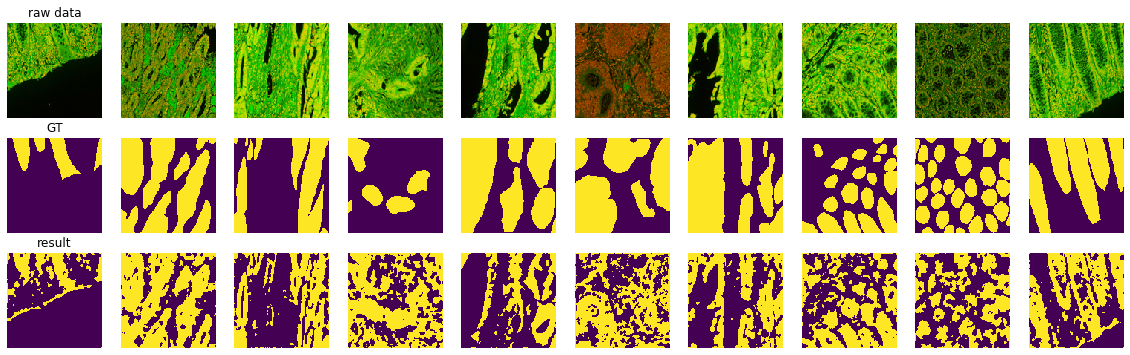

In [74]:
#now check the output on test data:
sample_dice_callback = LambdaCallback(
    on_batch_end=lambda batch,logs: print("Sample {0}: dice score {1}\n".format(batch, 1-logs['loss'])))
#callbacks within evaluate only work for keras<2.0 -.- FML.
#evaluacija = model.evaluate(x_test, np.expand_dims(y_test,-1), batch_size=1, callbacks=[sample_dice_callback])
eval_losses=[]
eval_accs=[]
eval_dices=[]
y_t = y_test[:,np.newaxis]
for i in range(x_test.shape[0]):
    x_t = np.expand_dims(x_test[i,:], 0)
    evaluacija = model.evaluate(x_t, np.expand_dims(y_t[i,:],0), batch_size=1, verbose=0)
    eval_losses.append(evaluacija[0])
    eval_accs.append(evaluacija[1])
    eval_dices.append(1-evaluacija[0])
print("Test set evaluation \nAvg loss: ", np.mean(eval_losses), ", avg acc: ", np.mean(eval_accs), ", avg Dice: ", np.mean(eval_dices))

test_out = model.predict_classes(x_test)
plotWARWICKdata(x_test[10:20,:], y_test[10:20,:], np.squeeze(test_out[10:20,:]), incols=False)


In [79]:
#apparently, we're getting somewhere. Run again, this and another network
#(with subsampling and up convolutions), but for longer!

model1 = Sequential()
model1.add(BatchNormalization(input_shape=(128, 128, 2)))
model1.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2)))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(1, (1,1), padding='same'))
model1.add(Activation('sigmoid'))

################################################################################
model2 = Sequential()
model2.add(BatchNormalization(input_shape=(128, 128, 2)))
model2.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3,3), padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None))
model2.add(Activation('relu'))
model2.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', output_padding=None))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(1, (1,1), padding='same'))
model2.add(Activation('sigmoid'))

####################
model1.summary()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_50 (Batc (None, 128, 128, 2)       8         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 128, 128, 32)      608       
_________________________________________________________________
activation_80 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_81 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 128, 128)     73856     
__________

In [81]:
y_train_expanded = np.expand_dims(y_train, axis=-1)

x_tren, x_valid, y_tren, y_valid = train_test_split(x_train, y_train_expanded, test_size=0.2, random_state=339)
model1.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])
hist_m1 = model1.fit(x_tren, y_tren, epochs=50, batch_size=minibatch, validation_data=(x_valid, y_valid))

model2.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])
hist_m2 = model2.fit(x_tren, y_tren, epochs=50, batch_size=minibatch, validation_data=(x_valid, y_valid))


Train on 68 samples, validate on 17 samples
Epoch 1/50
68/68 [==============================] - 34s 504ms/step - loss: 0.4158 - acc: 0.4673 - val_loss: 0.3903 - val_acc: 0.6130
Epoch 2/50
68/68 [==============================] - 33s 491ms/step - loss: 0.2921 - acc: 0.6337 - val_loss: 0.5081 - val_acc: 0.4658
Epoch 3/50
68/68 [==============================] - 33s 480ms/step - loss: 0.4073 - acc: 0.5075 - val_loss: 0.3855 - val_acc: 0.6495
Epoch 4/50
68/68 [==============================] - 33s 480ms/step - loss: 0.2302 - acc: 0.6748 - val_loss: 0.4939 - val_acc: 0.6118
Epoch 5/50
68/68 [==============================] - 33s 479ms/step - loss: 0.2337 - acc: 0.6794 - val_loss: 0.8749 - val_acc: 0.4881
Epoch 6/50
68/68 [==============================] - 33s 481ms/step - loss: 0.2408 - acc: 0.6575 - val_loss: 0.6293 - val_acc: 0.5700
Epoch 7/50
68/68 [==============================] - 36s 529ms/step - loss: 0.2044 - acc: 0.7033 - val_loss: 0.3717 - val_acc: 0.6474
Epoch 8/50
68/68 [=======

Epoch 12/50
68/68 [==============================] - 7s 109ms/step - loss: 0.1609 - acc: 0.7985 - val_loss: 0.1663 - val_acc: 0.7729
Epoch 13/50
68/68 [==============================] - 7s 109ms/step - loss: 0.1514 - acc: 0.8091 - val_loss: 0.1857 - val_acc: 0.7512
Epoch 14/50
68/68 [==============================] - 8s 112ms/step - loss: 0.1587 - acc: 0.7962 - val_loss: 0.1616 - val_acc: 0.7765
Epoch 15/50
68/68 [==============================] - 7s 110ms/step - loss: 0.1444 - acc: 0.8174 - val_loss: 0.1716 - val_acc: 0.7560
Epoch 16/50
68/68 [==============================] - 8s 112ms/step - loss: 0.1482 - acc: 0.8045 - val_loss: 0.1680 - val_acc: 0.7585
Epoch 17/50
68/68 [==============================] - 7s 110ms/step - loss: 0.1451 - acc: 0.8101 - val_loss: 0.1554 - val_acc: 0.7709
Epoch 18/50
68/68 [==============================] - 8s 111ms/step - loss: 0.1350 - acc: 0.8319 - val_loss: 0.1580 - val_acc: 0.7760
Epoch 19/50
68/68 [==============================] - 7s 109ms/step - 

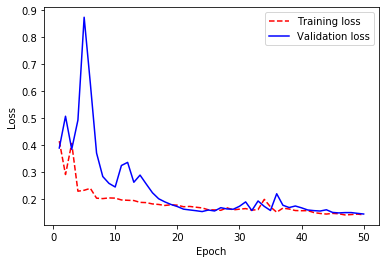

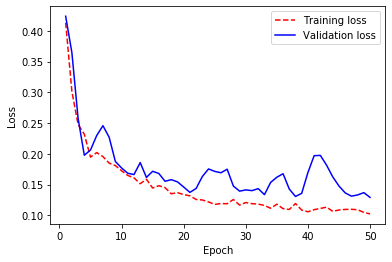

Average test losses: 
 Model 1:  0.1807323455810547 ,  Model 2:  0.14710041284561157


In [84]:
plot_history(hist_m1.history)
plot_history(hist_m2.history)

evaluacija1 = model1.evaluate(x_test, np.expand_dims(y_test,-1), verbose=0)
evaluacija2 = model2.evaluate(x_test, np.expand_dims(y_test,-1), verbose=0)

print("Average test losses: \n Model 1: ", evaluacija1[0], ",  Model 2: ", evaluacija2[0])

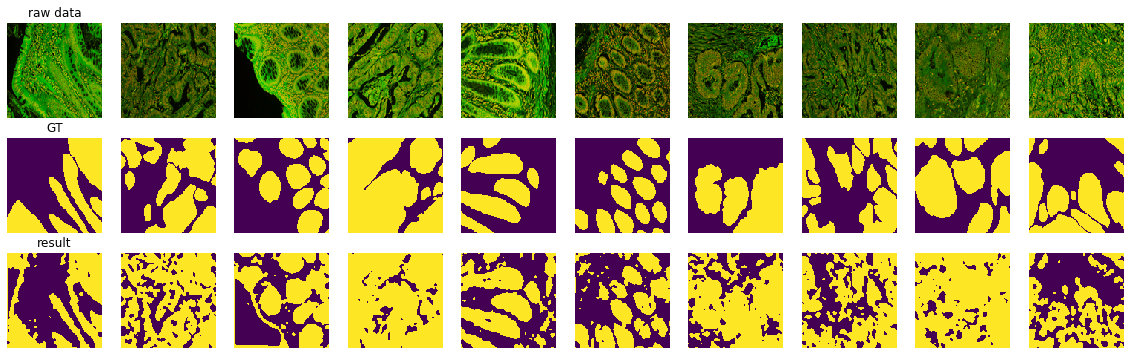

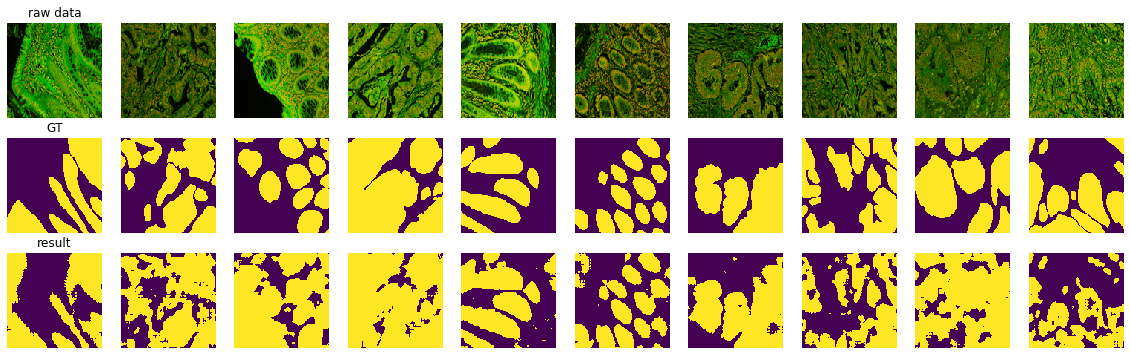

In [86]:
out1 = model1.predict_classes(x_valid)
out2 = model2.predict_classes(x_valid)
plotWARWICKdata(x_valid[0:10,:], np.squeeze(y_valid[0:10,:]), np.squeeze(out1[0:10,:]), incols=False)
plotWARWICKdata(x_valid[0:10,:], np.squeeze(y_valid[0:10,:]), np.squeeze(out2[0:10,:]), incols=False)


In [87]:
minibatch

64

In [7]:
#we see that model 2 is better. Let's train it with all the data, and for longer.
#before we had minibatch 64, let's now use 128.
minibatch = 128
y_test_expanded = np.expand_dims(y_test, axis=-1)
histori = model2.fit(x_train, y_train_expanded, epochs=80, batch_size=minibatch, validation_data=(x_test, y_test_expanded))

plot_history(histori.history)
out = model2.predict_classes(x_test)
plotWARWICKdata(x_test[0:10,:], np.squeeze(y_test[0:10,:]), np.squeeze(out[0:10,:]), incols=False)


NameError: name 'model2' is not defined

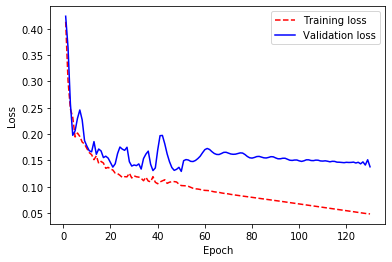

In [89]:
#join both histories:
new_history = {i: hist_m2.history[i] + histori.history[i] for i in histori.history}
plot_history(new_history)

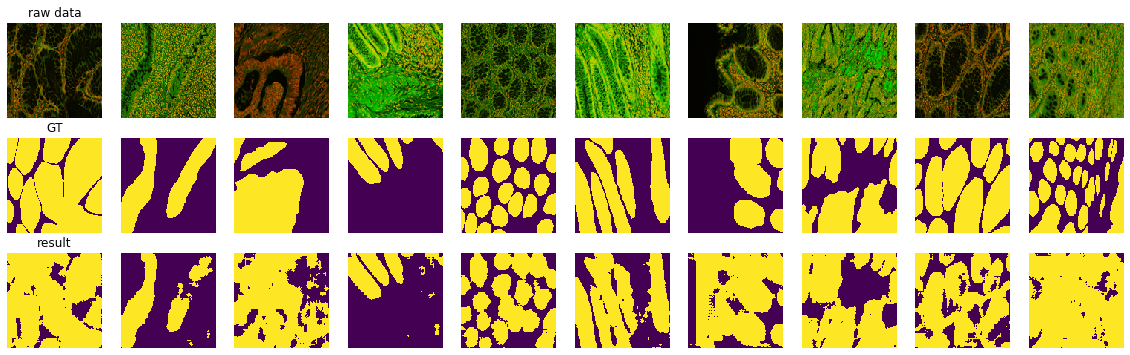

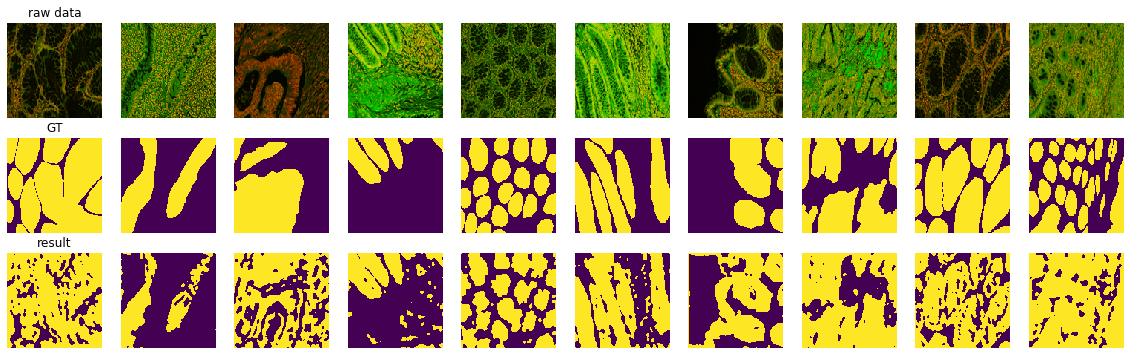

In [91]:
out1 = model1.predict_classes(x_test)
plotWARWICKdata(x_test[0:10,:], np.squeeze(y_test[0:10,:]), np.squeeze(out[0:10,:]), incols=False)
plotWARWICKdata(x_test[0:10,:], np.squeeze(y_test[0:10,:]), np.squeeze(out1[0:10,:]), incols=False)


Train on 85 samples, validate on 60 samples
Epoch 1/150
85/85 [==============================] - 11s 131ms/step - loss: 0.3762 - acc: 0.5055 - val_loss: 0.4103 - val_acc: 0.5215
Epoch 2/150
85/85 [==============================] - 9s 108ms/step - loss: 0.3172 - acc: 0.5735 - val_loss: 0.3281 - val_acc: 0.6225
Epoch 3/150
85/85 [==============================] - 10s 115ms/step - loss: 0.2479 - acc: 0.6758 - val_loss: 0.2698 - val_acc: 0.6266
Epoch 4/150
85/85 [==============================] - 9s 110ms/step - loss: 0.2176 - acc: 0.7243 - val_loss: 0.2371 - val_acc: 0.6881
Epoch 5/150
85/85 [==============================] - 10s 115ms/step - loss: 0.2583 - acc: 0.6673 - val_loss: 0.2852 - val_acc: 0.6183
Epoch 6/150
85/85 [==============================] - 10s 116ms/step - loss: 0.1832 - acc: 0.7629 - val_loss: 0.3160 - val_acc: 0.6057
Epoch 7/150
85/85 [==============================] - 10s 112ms/step - loss: 0.1898 - acc: 0.7495 - val_loss: 0.2259 - val_acc: 0.7037
Epoch 8/150
85/85 [=

Epoch 62/150
85/85 [==============================] - 11s 124ms/step - loss: 0.0658 - acc: 0.9161 - val_loss: 0.1419 - val_acc: 0.8157
Epoch 63/150
85/85 [==============================] - 10s 120ms/step - loss: 0.0649 - acc: 0.9174 - val_loss: 0.1375 - val_acc: 0.8230
Epoch 64/150
85/85 [==============================] - 10s 121ms/step - loss: 0.0646 - acc: 0.9178 - val_loss: 0.1290 - val_acc: 0.8331
Epoch 65/150
85/85 [==============================] - 11s 124ms/step - loss: 0.0625 - acc: 0.9200 - val_loss: 0.1347 - val_acc: 0.8197
Epoch 66/150
85/85 [==============================] - 10s 117ms/step - loss: 0.0611 - acc: 0.9222 - val_loss: 0.1389 - val_acc: 0.8115
Epoch 67/150
85/85 [==============================] - 10s 118ms/step - loss: 0.0605 - acc: 0.9231 - val_loss: 0.1304 - val_acc: 0.8223
Epoch 68/150
85/85 [==============================] - 10s 118ms/step - loss: 0.0589 - acc: 0.9252 - val_loss: 0.1313 - val_acc: 0.8220
Epoch 69/150
85/85 [==============================] - 1

Epoch 123/150
85/85 [==============================] - 10s 118ms/step - loss: 0.0283 - acc: 0.9640 - val_loss: 0.1408 - val_acc: 0.8112
Epoch 124/150
85/85 [==============================] - 10s 117ms/step - loss: 0.0286 - acc: 0.9640 - val_loss: 0.1373 - val_acc: 0.8224
Epoch 125/150
85/85 [==============================] - 10s 117ms/step - loss: 0.0277 - acc: 0.9649 - val_loss: 0.1456 - val_acc: 0.8111
Epoch 126/150
85/85 [==============================] - 10s 119ms/step - loss: 0.0277 - acc: 0.9647 - val_loss: 0.1423 - val_acc: 0.8116
Epoch 127/150
85/85 [==============================] - 11s 126ms/step - loss: 0.0285 - acc: 0.9641 - val_loss: 0.1251 - val_acc: 0.8391
Epoch 128/150
85/85 [==============================] - 10s 118ms/step - loss: 0.0281 - acc: 0.9642 - val_loss: 0.1352 - val_acc: 0.8272
Epoch 129/150
85/85 [==============================] - 10s 118ms/step - loss: 0.0284 - acc: 0.9635 - val_loss: 0.1280 - val_acc: 0.8363
Epoch 130/150
85/85 [===========================

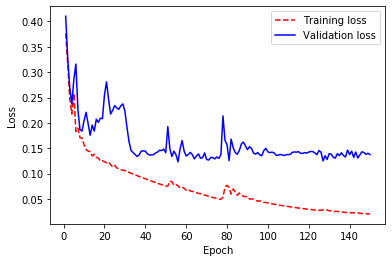

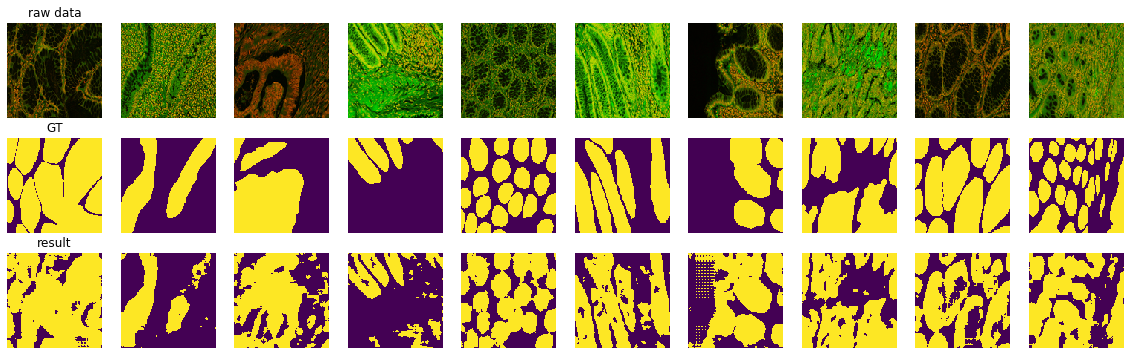

In [94]:
histori = model2.fit(x_train, y_train_expanded, epochs=150, batch_size=minibatch, validation_data=(x_test, y_test_expanded))

plot_history(histori.history)
out = model2.predict_classes(x_test)
plotWARWICKdata(x_test[0:10,:], np.squeeze(y_test[0:10,:]), np.squeeze(out[0:10,:]), incols=False)


In [116]:
#now also evaluate, on per sample basis, and see which samples are really bad...
evaluacija0 = model2.evaluate(x_test, y_test_expanded, batch_size=1)
print(evaluacija0)
eval_losses=[]
eval_accs=[]
eval_dices=[]
y_t = y_test[:,np.newaxis]
for i in range(x_test.shape[0]):
    x_t = np.expand_dims(x_test[i,:], 0)
    evaluacija = model2.evaluate(x_t, np.expand_dims(y_t[i,:],-1), batch_size=1, verbose=0)
    eval_losses.append(evaluacija[0])
    eval_accs.append(evaluacija[1])
    eval_dices.append(1-evaluacija[0])
print("Test set evaluation \nAvg loss: ", np.mean(eval_losses), ", avg acc: ", np.mean(eval_accs), ", avg Dice: ", np.mean(eval_dices))



60/60 [==============================] - 2s 28ms/step
[0.15437299211819966, 0.82283935546875]
Test set evaluation 
Avg loss:  0.15437299211819966 , avg acc:  0.82283935546875 , avg Dice:  0.8456270078818003


In [117]:
eval_dices

[0.943051278591156,
 0.8849114179611206,
 0.7714840769767761,
 0.7888132333755493,
 0.9178776144981384,
 0.9127396941184998,
 0.7677303552627563,
 0.911952555179596,
 0.8870773911476135,
 0.8400862812995911,
 0.5354565382003784,
 0.9186127185821533,
 0.8191154599189758,
 0.601691722869873,
 0.8409348130226135,
 0.8906866908073425,
 0.9061508774757385,
 0.7549844980239868,
 0.8969252705574036,
 0.8015926480293274,
 0.7047044634819031,
 0.8549845218658447,
 0.7498436570167542,
 0.8046365976333618,
 0.9001370072364807,
 0.8353669047355652,
 0.9078976511955261,
 0.8818928599357605,
 0.8728731274604797,
 0.9418087005615234,
 0.8854279518127441,
 0.8386019468307495,
 0.8224796652793884,
 0.7686331868171692,
 0.9480857253074646,
 0.9522542953491211,
 0.9290826320648193,
 0.7753929495811462,
 0.6567543148994446,
 0.8864966630935669,
 0.6337190270423889,
 0.8893899917602539,
 0.8922781348228455,
 0.895584225654602,
 0.7432369589805603,
 0.9114843010902405,
 0.8875611424446106,
 0.90703564882278

In [109]:
x_test.shape

(60, 128, 128, 2)

In [111]:
evaluacija0 = model2.evaluate(x_test, y_test_expanded, batch_size=10)
print(evaluacija0)
evaluacija0 = model2.evaluate(x_test, y_test_expanded, batch_size=3, verbose=1)
print(evaluacija0)
evaluacija0 = model2.evaluate(x_test, y_test_expanded, batch_size=1, verbose=1)
print(evaluacija0)
evaluacija0 = model2.evaluate(x_test, y_test_expanded, batch_size=60)
print(evaluacija0)

60/60 [==============================] - 1s 24ms/step
[0.1381820539633433, 0.8228393693765005]
60/60 [==============================] - 1s 25ms/step
[0.14014312624931335, 0.8228393524885178]
60/60 [==============================] - 2s 26ms/step
[0.15437299211819966, 0.82283935546875]
60/60 [==============================] - 1s 24ms/step
[0.1375531554222107, 0.8228393793106079]


In [118]:
#just in case, let's try another network:
model3 = Sequential()
model3.add(BatchNormalization(input_shape=(128, 128, 2)))
model3.add(Conv2D(64, (3,3), padding='same', input_shape=(128, 128, 2)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3,3), padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3,3), padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(256, (3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2DTranspose(128, (3,3), strides=(2, 2), padding='same', output_padding=None))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(Dropout(0.2))
model3.add(Conv2D(1, (1,1), padding='same'))
model3.add(Activation('sigmoid'))


W0816 19:21:30.906745 139758102185792 deprecation.py:506] From /home/eva/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 85 samples, validate on 60 samples
Epoch 1/100
85/85 [==============================] - 13s 151ms/step - loss: 0.3451 - acc: 0.5457 - val_loss: 0.5480 - val_acc: 0.4852
Epoch 2/100
85/85 [==============================] - 9s 110ms/step - loss: 0.2750 - acc: 0.6311 - val_loss: 0.2527 - val_acc: 0.6792
Epoch 3/100
85/85 [==============================] - 9s 110ms/step - loss: 0.2158 - acc: 0.6723 - val_loss: 0.3604 - val_acc: 0.6432
Epoch 4/100
85/85 [==============================] - 10s 112ms/step - loss: 0.1912 - acc: 0.7358 - val_loss: 0.3532 - val_acc: 0.6874
Epoch 5/100
85/85 [==============================] - 10s 113ms/step - loss: 0.1687 - acc: 0.7745 - val_loss: 0.2225 - val_acc: 0.7581
Epoch 6/100
85/85 [==============================] - 10s 112ms/step - loss: 0.1563 - acc: 0.7924 - val_loss: 0.2428 - val_acc: 0.6958
Epoch 7/100
85/85 [==============================] - 10s 113ms/step - loss: 0.1501 - acc: 0.8047 - val_loss: 0.1924 - val_acc: 0.7555
Epoch 8/100
85/85 [=

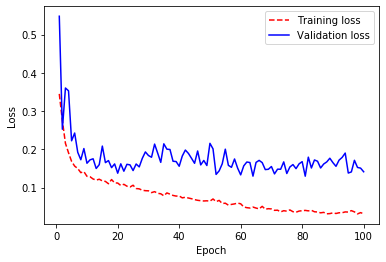

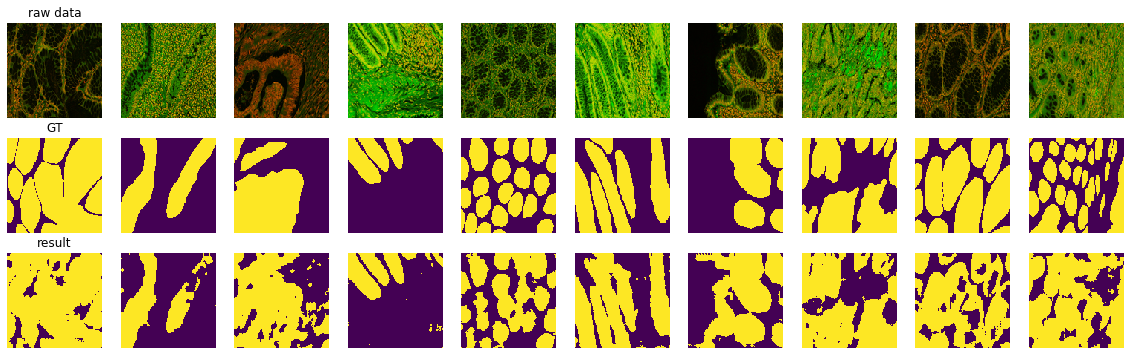

In [122]:
model2 = Sequential()
model2.add(BatchNormalization(input_shape=(128, 128, 2)))
model2.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3,3), padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None))
model2.add(Activation('relu'))
model2.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', output_padding=None))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(1, (1,1), padding='same'))
model2.add(Activation('sigmoid'))



minibatch = 32
model2.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])
y_test_expanded = np.expand_dims(y_test, axis=-1)
histori = model2.fit(x_train, y_train_expanded, epochs=100, batch_size=minibatch, validation_data=(x_test, y_test_expanded))

plot_history(histori.history)
out = model2.predict_classes(x_test)
plotWARWICKdata(x_test[0:10,:], np.squeeze(y_test[0:10,:]), np.squeeze(out[0:10,:]), incols=False)


In [123]:
#now also evaluate, on per sample basis, and see which samples are really bad...
evaluacija0 = model2.evaluate(x_test, y_test_expanded, batch_size=1)
print(evaluacija0)
eval_losses=[]
eval_accs=[]
eval_dices=[]
y_t = y_test[:,np.newaxis]
for i in range(x_test.shape[0]):
    x_t = np.expand_dims(x_test[i,:], 0)
    evaluacija = model2.evaluate(x_t, np.expand_dims(y_t[i,:],-1), batch_size=1, verbose=0)
    eval_losses.append(evaluacija[0])
    eval_accs.append(evaluacija[1])
    eval_dices.append(1-evaluacija[0])
print("Test set evaluation \nAvg loss: ", np.mean(eval_losses), ", avg acc: ", np.mean(eval_accs), ", avg Dice: ", np.mean(eval_dices))



60/60 [==============================] - 2s 34ms/step
[0.1569900244474411, 0.8142466227213542]
Test set evaluation 
Avg loss:  0.1569900244474411 , avg acc:  0.8142466227213542 , avg Dice:  0.8430099755525589


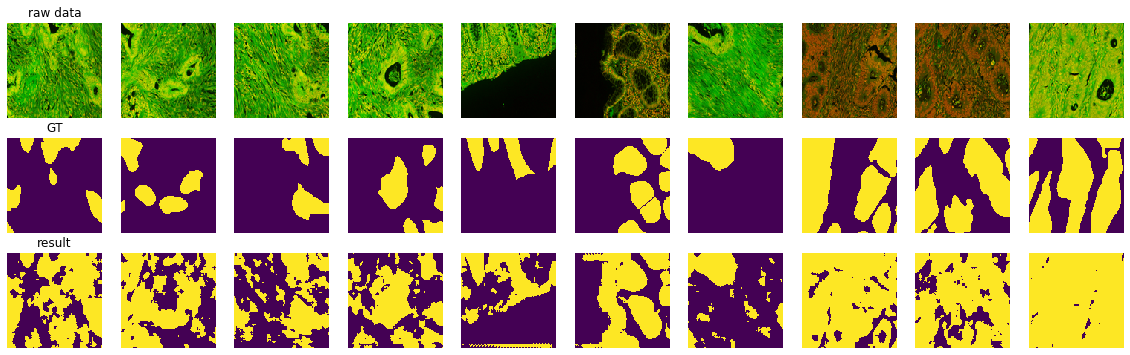

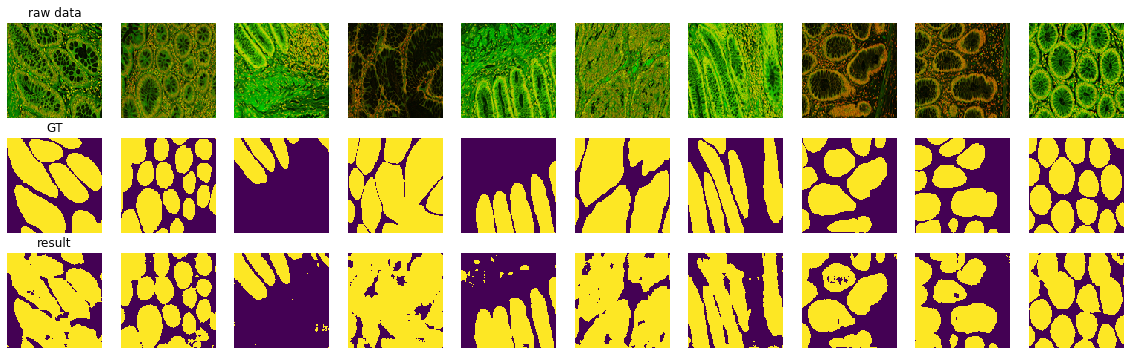

In [125]:
sortirani = np.argsort(eval_dices)

#plot the worst
plotWARWICKdata(x_test[sortirani[0:10],:], np.squeeze(y_test[sortirani[0:10],:]), np.squeeze(out[sortirani[0:10],:]), incols=False)
#plot the best
plotWARWICKdata(x_test[sortirani[-10:],:], np.squeeze(y_test[sortirani[-10:],:]), np.squeeze(out[sortirani[-10:],:]), incols=False)


# ZADNJA NALOGA, PRIMERJANJA METOD REGULARIZACIJE

Train on 68 samples, validate on 17 samples
Epoch 1/1000
68/68 [==============================] - 8s 124ms/step - loss: 0.3264 - acc: 0.5020 - val_loss: 0.2721 - val_acc: 0.5384
Epoch 2/1000
68/68 [==============================] - 5s 75ms/step - loss: 0.3027 - acc: 0.4932 - val_loss: 0.2668 - val_acc: 0.5384
Epoch 3/1000
68/68 [==============================] - 5s 75ms/step - loss: 0.2892 - acc: 0.4932 - val_loss: 0.2625 - val_acc: 0.5384
Epoch 4/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.2926 - acc: 0.4932 - val_loss: 0.2647 - val_acc: 0.5384
Epoch 5/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.2822 - acc: 0.4932 - val_loss: 0.2832 - val_acc: 0.5384
Epoch 6/1000
68/68 [==============================] - 6s 84ms/step - loss: 0.2872 - acc: 0.4932 - val_loss: 0.2529 - val_acc: 0.5384
Epoch 7/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.2685 - acc: 0.4932 - val_loss: 0.2591 - val_acc: 0.5384
Epoch 8/1000
68/68 [====

Epoch 62/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1285 - acc: 0.8341 - val_loss: 0.1725 - val_acc: 0.7805
Epoch 63/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1432 - acc: 0.8290 - val_loss: 0.1484 - val_acc: 0.7829
Epoch 64/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1336 - acc: 0.8264 - val_loss: 0.1401 - val_acc: 0.8100
Epoch 65/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1263 - acc: 0.8440 - val_loss: 0.1379 - val_acc: 0.8046
Epoch 66/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1228 - acc: 0.8456 - val_loss: 0.1350 - val_acc: 0.8107
Epoch 67/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1249 - acc: 0.8417 - val_loss: 0.1503 - val_acc: 0.7772
Epoch 68/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1352 - acc: 0.8205 - val_loss: 0.1557 - val_acc: 0.7975
Epoch 69/1000
68/68 [==============================] - 5s 78ms

Epoch 123/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1002 - acc: 0.8773 - val_loss: 0.1173 - val_acc: 0.8349
Epoch 124/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0987 - acc: 0.8755 - val_loss: 0.1202 - val_acc: 0.8393
Epoch 125/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0941 - acc: 0.8842 - val_loss: 0.1245 - val_acc: 0.8201
Epoch 126/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1045 - acc: 0.8627 - val_loss: 0.1268 - val_acc: 0.8213
Epoch 127/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1005 - acc: 0.8737 - val_loss: 0.1196 - val_acc: 0.8368
Epoch 128/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0932 - acc: 0.8825 - val_loss: 0.1207 - val_acc: 0.8365
Epoch 129/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0914 - acc: 0.8862 - val_loss: 0.1228 - val_acc: 0.8217
Epoch 130/1000
68/68 [==============================] -

Epoch 244/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.0593 - acc: 0.9261 - val_loss: 0.1131 - val_acc: 0.8405
Epoch 245/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0601 - acc: 0.9238 - val_loss: 0.1213 - val_acc: 0.8442
Epoch 246/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.0617 - acc: 0.9239 - val_loss: 0.1125 - val_acc: 0.8413
Epoch 247/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0611 - acc: 0.9213 - val_loss: 0.1155 - val_acc: 0.8472
Epoch 248/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0577 - acc: 0.9276 - val_loss: 0.1117 - val_acc: 0.8470
Epoch 249/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0591 - acc: 0.9248 - val_loss: 0.1174 - val_acc: 0.8473
Epoch 250/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.0581 - acc: 0.9279 - val_loss: 0.1129 - val_acc: 0.8409
Epoch 251/1000
68/68 [==============================] -

Epoch 305/1000
68/68 [==============================] - 6s 83ms/step - loss: 0.0467 - acc: 0.9428 - val_loss: 0.1191 - val_acc: 0.8450
Epoch 306/1000
68/68 [==============================] - 7s 110ms/step - loss: 0.0452 - acc: 0.9446 - val_loss: 0.1157 - val_acc: 0.8468
Epoch 307/1000
68/68 [==============================] - 6s 88ms/step - loss: 0.0446 - acc: 0.9451 - val_loss: 0.1157 - val_acc: 0.8480
Epoch 308/1000
68/68 [==============================] - 6s 90ms/step - loss: 0.0438 - acc: 0.9457 - val_loss: 0.1172 - val_acc: 0.8487
Epoch 309/1000
68/68 [==============================] - 6s 84ms/step - loss: 0.0435 - acc: 0.9462 - val_loss: 0.1161 - val_acc: 0.8471
Epoch 310/1000
68/68 [==============================] - 6s 81ms/step - loss: 0.0433 - acc: 0.9464 - val_loss: 0.1153 - val_acc: 0.8464
Epoch 311/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0430 - acc: 0.9468 - val_loss: 0.1150 - val_acc: 0.8465
Epoch 312/1000
68/68 [==============================] 

Epoch 426/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0273 - acc: 0.9665 - val_loss: 0.1228 - val_acc: 0.8418
Epoch 427/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0274 - acc: 0.9665 - val_loss: 0.1303 - val_acc: 0.8384
Epoch 428/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0283 - acc: 0.9653 - val_loss: 0.1231 - val_acc: 0.8409
Epoch 429/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0290 - acc: 0.9640 - val_loss: 0.1238 - val_acc: 0.8431
Epoch 430/1000
68/68 [==============================] - 6s 87ms/step - loss: 0.0274 - acc: 0.9661 - val_loss: 0.1251 - val_acc: 0.8407
Epoch 431/1000
68/68 [==============================] - 6s 83ms/step - loss: 0.0270 - acc: 0.9669 - val_loss: 0.1285 - val_acc: 0.8394
Epoch 432/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0268 - acc: 0.9673 - val_loss: 0.1258 - val_acc: 0.8384
Epoch 433/1000
68/68 [==============================] -

Epoch 487/1000
68/68 [==============================] - 6s 88ms/step - loss: 0.0226 - acc: 0.9723 - val_loss: 0.1256 - val_acc: 0.8428
Epoch 488/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0229 - acc: 0.9725 - val_loss: 0.1261 - val_acc: 0.8406
Epoch 489/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0229 - acc: 0.9721 - val_loss: 0.1253 - val_acc: 0.8410
Epoch 490/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0227 - acc: 0.9721 - val_loss: 0.1259 - val_acc: 0.8431
Epoch 491/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.0224 - acc: 0.9726 - val_loss: 0.1280 - val_acc: 0.8400
Epoch 492/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0225 - acc: 0.9727 - val_loss: 0.1260 - val_acc: 0.8390
Epoch 493/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0223 - acc: 0.9724 - val_loss: 0.1276 - val_acc: 0.8425
Epoch 494/1000
68/68 [==============================] -

Epoch 548/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0235 - acc: 0.9720 - val_loss: 0.1306 - val_acc: 0.8378
Epoch 549/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0216 - acc: 0.9738 - val_loss: 0.1268 - val_acc: 0.8415
Epoch 550/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0237 - acc: 0.9713 - val_loss: 0.1259 - val_acc: 0.8385
Epoch 551/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0245 - acc: 0.9699 - val_loss: 0.1386 - val_acc: 0.8329
Epoch 552/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0253 - acc: 0.9699 - val_loss: 0.1261 - val_acc: 0.8408
Epoch 553/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0237 - acc: 0.9705 - val_loss: 0.1297 - val_acc: 0.8397
Epoch 554/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0228 - acc: 0.9725 - val_loss: 0.1347 - val_acc: 0.8338
Epoch 555/1000
68/68 [==============================] -

Epoch 609/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0170 - acc: 0.9796 - val_loss: 0.1354 - val_acc: 0.8377
Epoch 610/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0179 - acc: 0.9783 - val_loss: 0.1300 - val_acc: 0.8378
Epoch 611/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0181 - acc: 0.9782 - val_loss: 0.1350 - val_acc: 0.8373
Epoch 612/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0172 - acc: 0.9793 - val_loss: 0.1305 - val_acc: 0.8384
Epoch 613/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0169 - acc: 0.9795 - val_loss: 0.1310 - val_acc: 0.8385
Epoch 614/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0168 - acc: 0.9796 - val_loss: 0.1372 - val_acc: 0.8373
Epoch 615/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0169 - acc: 0.9794 - val_loss: 0.1354 - val_acc: 0.8330
Epoch 616/1000
68/68 [==============================] -

Epoch 670/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0136 - acc: 0.9840 - val_loss: 0.1329 - val_acc: 0.8375
Epoch 671/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0135 - acc: 0.9841 - val_loss: 0.1337 - val_acc: 0.8370
Epoch 672/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0143 - acc: 0.9832 - val_loss: 0.1488 - val_acc: 0.8297
Epoch 673/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0175 - acc: 0.9782 - val_loss: 0.1324 - val_acc: 0.8394
Epoch 674/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0192 - acc: 0.9772 - val_loss: 0.1325 - val_acc: 0.8376
Epoch 675/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0197 - acc: 0.9764 - val_loss: 0.1463 - val_acc: 0.8322
Epoch 676/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0203 - acc: 0.9755 - val_loss: 0.1336 - val_acc: 0.8398
Epoch 677/1000
68/68 [==============================] -

Epoch 731/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0127 - acc: 0.9851 - val_loss: 0.1361 - val_acc: 0.8350
Epoch 732/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0126 - acc: 0.9852 - val_loss: 0.1335 - val_acc: 0.8368
Epoch 733/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0124 - acc: 0.9855 - val_loss: 0.1356 - val_acc: 0.8364
Epoch 734/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0124 - acc: 0.9854 - val_loss: 0.1347 - val_acc: 0.8360
Epoch 735/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0124 - acc: 0.9856 - val_loss: 0.1372 - val_acc: 0.8349
Epoch 736/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0129 - acc: 0.9849 - val_loss: 0.1362 - val_acc: 0.8349
Epoch 737/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.0128 - acc: 0.9850 - val_loss: 0.1365 - val_acc: 0.8353
Epoch 738/1000
68/68 [==============================] -

Epoch 792/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0103 - acc: 0.9885 - val_loss: 0.1383 - val_acc: 0.8345
Epoch 793/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0104 - acc: 0.9884 - val_loss: 0.1393 - val_acc: 0.8342
Epoch 794/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0103 - acc: 0.9883 - val_loss: 0.1391 - val_acc: 0.8345
Epoch 795/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0104 - acc: 0.9884 - val_loss: 0.1380 - val_acc: 0.8348
Epoch 796/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.0102 - acc: 0.9885 - val_loss: 0.1390 - val_acc: 0.8345
Epoch 797/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.0102 - acc: 0.9886 - val_loss: 0.1386 - val_acc: 0.8343
Epoch 798/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0102 - acc: 0.9886 - val_loss: 0.1379 - val_acc: 0.8346
Epoch 799/1000
68/68 [==============================] -

Epoch 853/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0098 - acc: 0.9888 - val_loss: 0.1375 - val_acc: 0.8358
Epoch 854/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0102 - acc: 0.9878 - val_loss: 0.1409 - val_acc: 0.8351
Epoch 855/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0107 - acc: 0.9872 - val_loss: 0.1452 - val_acc: 0.8311
Epoch 856/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.0105 - acc: 0.9875 - val_loss: 0.1420 - val_acc: 0.8330
Epoch 857/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0102 - acc: 0.9881 - val_loss: 0.1408 - val_acc: 0.8309
Epoch 858/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0102 - acc: 0.9879 - val_loss: 0.1406 - val_acc: 0.8339
Epoch 859/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0098 - acc: 0.9885 - val_loss: 0.1461 - val_acc: 0.8318
Epoch 860/1000
68/68 [==============================] -

Epoch 974/1000
68/68 [==============================] - 6s 81ms/step - loss: 0.0070 - acc: 0.9928 - val_loss: 0.1453 - val_acc: 0.8305
Epoch 975/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0069 - acc: 0.9927 - val_loss: 0.1438 - val_acc: 0.8324
Epoch 976/1000
68/68 [==============================] - 6s 84ms/step - loss: 0.0069 - acc: 0.9928 - val_loss: 0.1434 - val_acc: 0.8320
Epoch 977/1000
68/68 [==============================] - 6s 91ms/step - loss: 0.0068 - acc: 0.9930 - val_loss: 0.1446 - val_acc: 0.8314
Epoch 978/1000
68/68 [==============================] - 6s 90ms/step - loss: 0.0068 - acc: 0.9929 - val_loss: 0.1438 - val_acc: 0.8315
Epoch 979/1000
68/68 [==============================] - 6s 90ms/step - loss: 0.0068 - acc: 0.9930 - val_loss: 0.1451 - val_acc: 0.8308
Epoch 980/1000
68/68 [==============================] - 6s 83ms/step - loss: 0.0068 - acc: 0.9930 - val_loss: 0.1449 - val_acc: 0.8315
Epoch 981/1000
68/68 [==============================] -

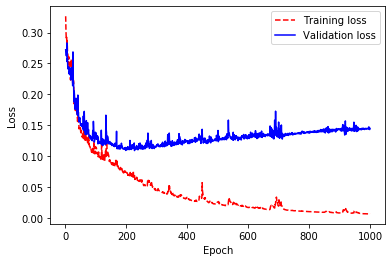

60/60 [==============================] - 2s 31ms/step
[0.18108391463756562, 0.8190938313802083]


In [141]:
#original:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None))
model.add(Activation('relu'))
model.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', output_padding=None))
model.add(Activation('relu'))
model.add(Conv2D(1, (1,1), padding='same'))
model.add(Activation('sigmoid'))


y_test_expanded = np.expand_dims(y_test, axis=-1)
x_tren, x_valid, y_tren, y_valid = train_test_split(x_train, y_train_expanded, test_size=0.2, random_state=339)
minibatch = 32
model.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])

hist = model.fit(x_tren, y_tren, epochs=1000, batch_size=minibatch, validation_data=(x_valid, y_valid))

plot_history(hist.history)
eval0 = model.evaluate(x_test, y_test_expanded, batch_size=1)
print(eval0)

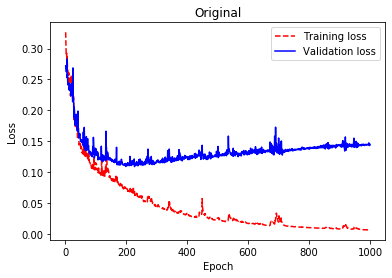

In [155]:
plot_history(hist.history, title = "Original")

In [142]:
evalt = model.evaluate(x_valid, y_valid, batch_size=1)
print(evalt)

17/17 [==============================] - 1s 31ms/step
[0.14639199831906488, 0.8308787626378676]


Train on 68 samples, validate on 17 samples
Epoch 1/1000
68/68 [==============================] - 14s 213ms/step - loss: 0.3339 - acc: 0.5624 - val_loss: 0.3327 - val_acc: 0.6555
Epoch 2/1000
68/68 [==============================] - 11s 157ms/step - loss: 0.2582 - acc: 0.6845 - val_loss: 0.9334 - val_acc: 0.4583
Epoch 3/1000
68/68 [==============================] - 10s 143ms/step - loss: 0.2598 - acc: 0.6607 - val_loss: 0.3312 - val_acc: 0.6540
Epoch 4/1000
68/68 [==============================] - 8s 123ms/step - loss: 0.2462 - acc: 0.6440 - val_loss: 0.8325 - val_acc: 0.4941
Epoch 5/1000
68/68 [==============================] - 9s 127ms/step - loss: 0.2371 - acc: 0.6004 - val_loss: 0.9455 - val_acc: 0.4566
Epoch 6/1000
68/68 [==============================] - 9s 133ms/step - loss: 0.2031 - acc: 0.6443 - val_loss: 0.8790 - val_acc: 0.4720
Epoch 7/1000
68/68 [==============================] - 9s 136ms/step - loss: 0.1843 - acc: 0.7692 - val_loss: 0.3278 - val_acc: 0.6794
Epoch 8/1000
68

68/68 [==============================] - 8s 122ms/step - loss: 0.0397 - acc: 0.9499 - val_loss: 0.1522 - val_acc: 0.8224
Epoch 122/1000
68/68 [==============================] - 8s 118ms/step - loss: 0.0354 - acc: 0.9557 - val_loss: 0.3165 - val_acc: 0.7056
Epoch 123/1000
68/68 [==============================] - 8s 120ms/step - loss: 0.0368 - acc: 0.9542 - val_loss: 0.2287 - val_acc: 0.7611
Epoch 124/1000
68/68 [==============================] - 8s 120ms/step - loss: 0.0438 - acc: 0.9458 - val_loss: 0.1462 - val_acc: 0.8309
Epoch 125/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0372 - acc: 0.9539 - val_loss: 0.1689 - val_acc: 0.8056
Epoch 126/1000
68/68 [==============================] - 8s 119ms/step - loss: 0.0392 - acc: 0.9510 - val_loss: 0.2505 - val_acc: 0.7476
Epoch 127/1000
68/68 [==============================] - 10s 141ms/step - loss: 0.0374 - acc: 0.9537 - val_loss: 0.3070 - val_acc: 0.7105
Epoch 128/1000
68/68 [==============================] - 9s 130

68/68 [==============================] - 8s 118ms/step - loss: 0.0143 - acc: 0.9819 - val_loss: 0.1108 - val_acc: 0.8571
Epoch 242/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0145 - acc: 0.9816 - val_loss: 0.1183 - val_acc: 0.8514
Epoch 243/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0127 - acc: 0.9842 - val_loss: 0.1246 - val_acc: 0.8475
Epoch 244/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0128 - acc: 0.9838 - val_loss: 0.1215 - val_acc: 0.8508
Epoch 245/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0124 - acc: 0.9844 - val_loss: 0.1138 - val_acc: 0.8557
Epoch 246/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0126 - acc: 0.9841 - val_loss: 0.1108 - val_acc: 0.8563
Epoch 247/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0120 - acc: 0.9849 - val_loss: 0.1121 - val_acc: 0.8531
Epoch 248/1000
68/68 [==============================] - 8s 117m

68/68 [==============================] - 8s 116ms/step - loss: 0.0072 - acc: 0.9911 - val_loss: 0.1158 - val_acc: 0.8551
Epoch 362/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0076 - acc: 0.9908 - val_loss: 0.1166 - val_acc: 0.8530
Epoch 363/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0070 - acc: 0.9913 - val_loss: 0.1181 - val_acc: 0.8493
Epoch 364/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0076 - acc: 0.9914 - val_loss: 0.1196 - val_acc: 0.8526
Epoch 365/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0070 - acc: 0.9913 - val_loss: 0.1331 - val_acc: 0.8470
Epoch 366/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0097 - acc: 0.9875 - val_loss: 0.1272 - val_acc: 0.8524
Epoch 367/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0088 - acc: 0.9889 - val_loss: 0.1228 - val_acc: 0.8511
Epoch 368/1000
68/68 [==============================] - 8s 116m

68/68 [==============================] - 8s 116ms/step - loss: 0.0052 - acc: 0.9936 - val_loss: 0.1353 - val_acc: 0.8302
Epoch 482/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0064 - acc: 0.9919 - val_loss: 0.1314 - val_acc: 0.8378
Epoch 483/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0055 - acc: 0.9933 - val_loss: 0.1262 - val_acc: 0.8494
Epoch 484/1000
68/68 [==============================] - 8s 122ms/step - loss: 0.0051 - acc: 0.9936 - val_loss: 0.1276 - val_acc: 0.8509
Epoch 485/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0047 - acc: 0.9941 - val_loss: 0.1213 - val_acc: 0.8540
Epoch 486/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0051 - acc: 0.9937 - val_loss: 0.1244 - val_acc: 0.8498
Epoch 487/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0046 - acc: 0.9945 - val_loss: 0.1329 - val_acc: 0.8428
Epoch 488/1000
68/68 [==============================] - 8s 116m

68/68 [==============================] - 8s 117ms/step - loss: 0.0031 - acc: 0.9963 - val_loss: 0.1297 - val_acc: 0.8481
Epoch 602/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.1241 - val_acc: 0.8517
Epoch 603/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0029 - acc: 0.9964 - val_loss: 0.1259 - val_acc: 0.8499
Epoch 604/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.1290 - val_acc: 0.8469
Epoch 605/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0029 - acc: 0.9970 - val_loss: 0.1318 - val_acc: 0.8447
Epoch 606/1000
68/68 [==============================] - 8s 118ms/step - loss: 0.0021 - acc: 0.9977 - val_loss: 0.1343 - val_acc: 0.8437
Epoch 607/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.1261 - val_acc: 0.8497
Epoch 608/1000
68/68 [==============================] - 8s 116m

68/68 [==============================] - 8s 116ms/step - loss: 0.0015 - acc: 0.9983 - val_loss: 0.1374 - val_acc: 0.8411
Epoch 722/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0016 - acc: 0.9983 - val_loss: 0.1322 - val_acc: 0.8452
Epoch 723/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0015 - acc: 0.9983 - val_loss: 0.1260 - val_acc: 0.8484
Epoch 724/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0013 - acc: 0.9986 - val_loss: 0.1267 - val_acc: 0.8446
Epoch 725/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0027 - acc: 0.9963 - val_loss: 0.1248 - val_acc: 0.8468
Epoch 726/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0014 - acc: 0.9984 - val_loss: 0.1343 - val_acc: 0.8314
Epoch 727/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0025 - acc: 0.9970 - val_loss: 0.1376 - val_acc: 0.8236
Epoch 728/1000
68/68 [==============================] - 8s 118m

Epoch 781/1000
68/68 [==============================] - 8s 118ms/step - loss: 9.3071e-04 - acc: 0.9990 - val_loss: 0.1294 - val_acc: 0.8479
Epoch 782/1000
68/68 [==============================] - 8s 117ms/step - loss: 8.1455e-04 - acc: 0.9993 - val_loss: 0.1318 - val_acc: 0.8445
Epoch 783/1000
68/68 [==============================] - 8s 117ms/step - loss: 8.9168e-04 - acc: 0.9992 - val_loss: 0.1335 - val_acc: 0.8425
Epoch 784/1000
68/68 [==============================] - 8s 117ms/step - loss: 9.6224e-04 - acc: 0.9991 - val_loss: 0.1309 - val_acc: 0.8465
Epoch 785/1000
68/68 [==============================] - 8s 116ms/step - loss: 8.1441e-04 - acc: 0.9992 - val_loss: 0.1289 - val_acc: 0.8508
Epoch 786/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0011 - acc: 0.9990 - val_loss: 0.1270 - val_acc: 0.8523
Epoch 787/1000
68/68 [==============================] - 8s 116ms/step - loss: 8.5669e-04 - acc: 0.9992 - val_loss: 0.1318 - val_acc: 0.8452
Epoch 788/1000
68/68 [==

68/68 [==============================] - 8s 120ms/step - loss: 0.0014 - acc: 0.9984 - val_loss: 0.1284 - val_acc: 0.8378
Epoch 842/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0020 - acc: 0.9976 - val_loss: 0.1253 - val_acc: 0.8464
Epoch 843/1000
68/68 [==============================] - 8s 118ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.1256 - val_acc: 0.8493
Epoch 844/1000
68/68 [==============================] - 8s 118ms/step - loss: 0.0015 - acc: 0.9984 - val_loss: 0.1316 - val_acc: 0.8463
Epoch 845/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0016 - acc: 0.9982 - val_loss: 0.1356 - val_acc: 0.8437
Epoch 846/1000
68/68 [==============================] - 8s 117ms/step - loss: 0.0017 - acc: 0.9980 - val_loss: 0.1304 - val_acc: 0.8467
Epoch 847/1000
68/68 [==============================] - 8s 116ms/step - loss: 0.0017 - acc: 0.9980 - val_loss: 0.1281 - val_acc: 0.8480
Epoch 848/1000
68/68 [==============================] - 8s 117m

68/68 [==============================] - 9s 129ms/step - loss: 0.0013 - acc: 0.9986 - val_loss: 0.1289 - val_acc: 0.8475
Epoch 961/1000
68/68 [==============================] - 9s 129ms/step - loss: 9.1678e-04 - acc: 0.9990 - val_loss: 0.1270 - val_acc: 0.8496
Epoch 962/1000
68/68 [==============================] - 9s 125ms/step - loss: 7.9586e-04 - acc: 0.9992 - val_loss: 0.1270 - val_acc: 0.8498
Epoch 963/1000
68/68 [==============================] - 8s 121ms/step - loss: 8.4508e-04 - acc: 0.9992 - val_loss: 0.1287 - val_acc: 0.8490
Epoch 964/1000
68/68 [==============================] - 9s 135ms/step - loss: 6.8882e-04 - acc: 0.9993 - val_loss: 0.1289 - val_acc: 0.8498
Epoch 965/1000
68/68 [==============================] - 10s 152ms/step - loss: 5.6907e-04 - acc: 0.9995 - val_loss: 0.1297 - val_acc: 0.8496
Epoch 966/1000
68/68 [==============================] - 10s 148ms/step - loss: 5.9134e-04 - acc: 0.9995 - val_loss: 0.1303 - val_acc: 0.8490
Epoch 967/1000
68/68 [===============

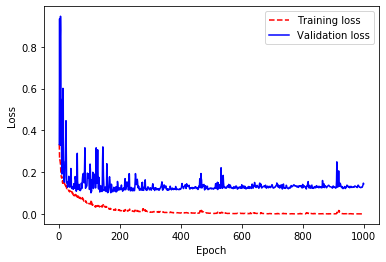

60/60 [==============================] - 3s 46ms/step
[0.1599217434724172, 0.8417449951171875]


In [143]:
#with batch norm all over
modelb = Sequential()
modelb.add(BatchNormalization(input_shape=(128,128,2)))
modelb.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2)))
modelb.add(Activation('relu'))
modelb.add(BatchNormalization())
modelb.add(Conv2D(64, (3,3), padding='same'))
modelb.add(MaxPooling2D(pool_size=(2,2)))
modelb.add(Activation('relu'))
modelb.add(BatchNormalization())
modelb.add(Conv2D(128, (3,3), padding='same'))
modelb.add(MaxPooling2D(pool_size=(2,2)))
modelb.add(Activation('relu'))
modelb.add(BatchNormalization())
modelb.add(Conv2D(128, (3,3), padding='same'))
modelb.add(Activation('relu'))
modelb.add(BatchNormalization())
modelb.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None))
modelb.add(Activation('relu'))
modelb.add(BatchNormalization())
modelb.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', output_padding=None))
modelb.add(Activation('relu'))
modelb.add(BatchNormalization())
modelb.add(Conv2D(1, (1,1), padding='same'))
modelb.add(Activation('sigmoid'))

modelb.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])

histb = modelb.fit(x_tren, y_tren, epochs=1000, batch_size=minibatch, validation_data=(x_valid, y_valid))

plot_history(histb.history)
eval0b = modelb.evaluate(x_test, y_test_expanded, batch_size=1)
print(eval0b)

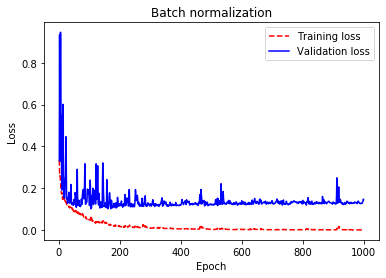

In [154]:
plot_history(histb.history, title = "Batch Normalization")

In [144]:
evaltb = modelb.evaluate(x_valid, y_valid, batch_size=1)
print(evaltb)

17/17 [==============================] - 1s 46ms/step
[0.15020600487204158, 0.8413301355698529]


Train on 68 samples, validate on 17 samples
Epoch 1/1000
68/68 [==============================] - 11s 164ms/step - loss: 0.5153 - acc: 0.5300 - val_loss: 0.3856 - val_acc: 0.5384
Epoch 2/1000
68/68 [==============================] - 8s 111ms/step - loss: 0.4066 - acc: 0.4932 - val_loss: 0.3234 - val_acc: 0.5384
Epoch 3/1000
68/68 [==============================] - 7s 110ms/step - loss: 0.3431 - acc: 0.4932 - val_loss: 0.3102 - val_acc: 0.5384
Epoch 4/1000
68/68 [==============================] - 7s 102ms/step - loss: 0.3249 - acc: 0.4932 - val_loss: 0.2870 - val_acc: 0.5384
Epoch 5/1000
68/68 [==============================] - 7s 110ms/step - loss: 0.3141 - acc: 0.4932 - val_loss: 0.2924 - val_acc: 0.5384
Epoch 6/1000
68/68 [==============================] - 7s 109ms/step - loss: 0.3105 - acc: 0.4932 - val_loss: 0.2842 - val_acc: 0.5384
Epoch 7/1000
68/68 [==============================] - 7s 103ms/step - loss: 0.3015 - acc: 0.4932 - val_loss: 0.2746 - val_acc: 0.5384
Epoch 8/1000
68/6

Epoch 62/1000
68/68 [==============================] - 6s 85ms/step - loss: 0.2524 - acc: 0.6623 - val_loss: 0.2523 - val_acc: 0.6398
Epoch 63/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.2508 - acc: 0.6756 - val_loss: 0.2475 - val_acc: 0.6371
Epoch 64/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.2550 - acc: 0.6469 - val_loss: 0.2459 - val_acc: 0.6329
Epoch 65/1000
68/68 [==============================] - 6s 89ms/step - loss: 0.2528 - acc: 0.6567 - val_loss: 0.2495 - val_acc: 0.6521
Epoch 66/1000
68/68 [==============================] - 6s 93ms/step - loss: 0.2501 - acc: 0.6589 - val_loss: 0.2455 - val_acc: 0.6506
Epoch 67/1000
68/68 [==============================] - 6s 93ms/step - loss: 0.2467 - acc: 0.6850 - val_loss: 0.2585 - val_acc: 0.6544
Epoch 68/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.2506 - acc: 0.6891 - val_loss: 0.2430 - val_acc: 0.6306
Epoch 69/1000
68/68 [==============================] - 5s 78ms

Epoch 123/1000
68/68 [==============================] - 7s 106ms/step - loss: 0.2030 - acc: 0.7801 - val_loss: 0.1943 - val_acc: 0.7551
Epoch 124/1000
68/68 [==============================] - 7s 109ms/step - loss: 0.2029 - acc: 0.7616 - val_loss: 0.2023 - val_acc: 0.7280
Epoch 125/1000
68/68 [==============================] - 8s 115ms/step - loss: 0.2001 - acc: 0.7685 - val_loss: 0.2327 - val_acc: 0.7348
Epoch 126/1000
68/68 [==============================] - 7s 105ms/step - loss: 0.2087 - acc: 0.7774 - val_loss: 0.2162 - val_acc: 0.6993
Epoch 127/1000
68/68 [==============================] - 6s 91ms/step - loss: 0.2312 - acc: 0.6967 - val_loss: 0.2210 - val_acc: 0.6817
Epoch 128/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.2129 - acc: 0.7368 - val_loss: 0.2335 - val_acc: 0.7333
Epoch 129/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.2185 - acc: 0.7668 - val_loss: 0.1962 - val_acc: 0.7361
Epoch 130/1000
68/68 [=============================

Epoch 244/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1738 - acc: 0.8134 - val_loss: 0.1790 - val_acc: 0.7645
Epoch 245/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1751 - acc: 0.7980 - val_loss: 0.1770 - val_acc: 0.7744
Epoch 246/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1722 - acc: 0.8088 - val_loss: 0.1778 - val_acc: 0.7826
Epoch 247/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1769 - acc: 0.8108 - val_loss: 0.1771 - val_acc: 0.7746
Epoch 248/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1720 - acc: 0.8088 - val_loss: 0.1850 - val_acc: 0.7790
Epoch 249/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1759 - acc: 0.8081 - val_loss: 0.1840 - val_acc: 0.7728
Epoch 250/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1742 - acc: 0.8059 - val_loss: 0.1769 - val_acc: 0.7777
Epoch 251/1000
68/68 [==============================] -

Epoch 365/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1601 - acc: 0.8307 - val_loss: 0.1653 - val_acc: 0.7947
Epoch 366/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1659 - acc: 0.8177 - val_loss: 0.1624 - val_acc: 0.8009
Epoch 367/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1611 - acc: 0.8283 - val_loss: 0.1640 - val_acc: 0.8013
Epoch 368/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1595 - acc: 0.8292 - val_loss: 0.1698 - val_acc: 0.7830
Epoch 369/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1641 - acc: 0.8178 - val_loss: 0.1655 - val_acc: 0.8037
Epoch 370/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1600 - acc: 0.8337 - val_loss: 0.1611 - val_acc: 0.8074
Epoch 371/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1610 - acc: 0.8131 - val_loss: 0.1606 - val_acc: 0.8086
Epoch 372/1000
68/68 [==============================] -

Epoch 426/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1535 - acc: 0.8373 - val_loss: 0.1595 - val_acc: 0.7998
Epoch 427/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1548 - acc: 0.8286 - val_loss: 0.1691 - val_acc: 0.8102
Epoch 428/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1549 - acc: 0.8424 - val_loss: 0.1608 - val_acc: 0.8033
Epoch 429/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1527 - acc: 0.8359 - val_loss: 0.1637 - val_acc: 0.8098
Epoch 430/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1521 - acc: 0.8436 - val_loss: 0.1591 - val_acc: 0.8010
Epoch 431/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1571 - acc: 0.8248 - val_loss: 0.1629 - val_acc: 0.7904
Epoch 432/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1570 - acc: 0.8245 - val_loss: 0.1585 - val_acc: 0.8147
Epoch 433/1000
68/68 [==============================] -

Epoch 487/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1527 - acc: 0.8438 - val_loss: 0.1556 - val_acc: 0.8113
Epoch 488/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1489 - acc: 0.8409 - val_loss: 0.1547 - val_acc: 0.8215
Epoch 489/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1473 - acc: 0.8466 - val_loss: 0.1524 - val_acc: 0.8184
Epoch 490/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1464 - acc: 0.8433 - val_loss: 0.1628 - val_acc: 0.8132
Epoch 491/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1532 - acc: 0.8447 - val_loss: 0.1574 - val_acc: 0.8068
Epoch 492/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1581 - acc: 0.8195 - val_loss: 0.1555 - val_acc: 0.8257
Epoch 493/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1589 - acc: 0.8396 - val_loss: 0.1654 - val_acc: 0.7923
Epoch 494/1000
68/68 [==============================] -

Epoch 548/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1471 - acc: 0.8530 - val_loss: 0.1530 - val_acc: 0.8142
Epoch 549/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1456 - acc: 0.8427 - val_loss: 0.1525 - val_acc: 0.8309
Epoch 550/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1463 - acc: 0.8550 - val_loss: 0.1525 - val_acc: 0.8160
Epoch 551/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1531 - acc: 0.8236 - val_loss: 0.1571 - val_acc: 0.7992
Epoch 552/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1485 - acc: 0.8330 - val_loss: 0.1525 - val_acc: 0.8266
Epoch 553/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1429 - acc: 0.8541 - val_loss: 0.1560 - val_acc: 0.8050
Epoch 554/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1567 - acc: 0.8195 - val_loss: 0.1524 - val_acc: 0.8259
Epoch 555/1000
68/68 [==============================] -

Epoch 609/1000
68/68 [==============================] - 6s 83ms/step - loss: 0.1430 - acc: 0.8536 - val_loss: 0.1553 - val_acc: 0.8107
Epoch 610/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1435 - acc: 0.8453 - val_loss: 0.1587 - val_acc: 0.8243
Epoch 611/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1475 - acc: 0.8555 - val_loss: 0.1535 - val_acc: 0.8158
Epoch 612/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1473 - acc: 0.8402 - val_loss: 0.1502 - val_acc: 0.8240
Epoch 613/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1407 - acc: 0.8555 - val_loss: 0.1506 - val_acc: 0.8292
Epoch 614/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1437 - acc: 0.8486 - val_loss: 0.1531 - val_acc: 0.8158
Epoch 615/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1448 - acc: 0.8461 - val_loss: 0.1580 - val_acc: 0.8126
Epoch 616/1000
68/68 [==============================] -

Epoch 670/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1408 - acc: 0.8521 - val_loss: 0.1593 - val_acc: 0.8257
Epoch 671/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1425 - acc: 0.8593 - val_loss: 0.1513 - val_acc: 0.8203
Epoch 672/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1436 - acc: 0.8442 - val_loss: 0.1554 - val_acc: 0.8277
Epoch 673/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1453 - acc: 0.8573 - val_loss: 0.1520 - val_acc: 0.8320
Epoch 674/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1414 - acc: 0.8583 - val_loss: 0.1504 - val_acc: 0.8223
Epoch 675/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1419 - acc: 0.8491 - val_loss: 0.1495 - val_acc: 0.8349
Epoch 676/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1437 - acc: 0.8599 - val_loss: 0.1524 - val_acc: 0.8134
Epoch 677/1000
68/68 [==============================] -

Epoch 731/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1485 - acc: 0.8568 - val_loss: 0.1471 - val_acc: 0.8350
Epoch 732/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1370 - acc: 0.8585 - val_loss: 0.1508 - val_acc: 0.8192
Epoch 733/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1394 - acc: 0.8567 - val_loss: 0.1591 - val_acc: 0.8204
Epoch 734/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1421 - acc: 0.8606 - val_loss: 0.1516 - val_acc: 0.8160
Epoch 735/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1440 - acc: 0.8430 - val_loss: 0.1477 - val_acc: 0.8325
Epoch 736/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1396 - acc: 0.8616 - val_loss: 0.1498 - val_acc: 0.8334
Epoch 737/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1381 - acc: 0.8601 - val_loss: 0.1471 - val_acc: 0.8315
Epoch 738/1000
68/68 [==============================] -

Epoch 792/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1376 - acc: 0.8572 - val_loss: 0.1467 - val_acc: 0.8285
Epoch 793/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1361 - acc: 0.8604 - val_loss: 0.1504 - val_acc: 0.8345
Epoch 794/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1391 - acc: 0.8643 - val_loss: 0.1478 - val_acc: 0.8260
Epoch 795/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1384 - acc: 0.8551 - val_loss: 0.1487 - val_acc: 0.8273
Epoch 796/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1351 - acc: 0.8622 - val_loss: 0.1464 - val_acc: 0.8352
Epoch 797/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1344 - acc: 0.8640 - val_loss: 0.1457 - val_acc: 0.8365
Epoch 798/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1364 - acc: 0.8650 - val_loss: 0.1471 - val_acc: 0.8288
Epoch 799/1000
68/68 [==============================] -

Epoch 853/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1340 - acc: 0.8661 - val_loss: 0.1478 - val_acc: 0.8296
Epoch 854/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1351 - acc: 0.8638 - val_loss: 0.1505 - val_acc: 0.8266
Epoch 855/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1353 - acc: 0.8649 - val_loss: 0.1524 - val_acc: 0.8282
Epoch 856/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1359 - acc: 0.8659 - val_loss: 0.1498 - val_acc: 0.8224
Epoch 857/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1398 - acc: 0.8520 - val_loss: 0.1485 - val_acc: 0.8327
Epoch 858/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1345 - acc: 0.8657 - val_loss: 0.1541 - val_acc: 0.8280
Epoch 859/1000
68/68 [==============================] - 5s 77ms/step - loss: 0.1392 - acc: 0.8639 - val_loss: 0.1501 - val_acc: 0.8214
Epoch 860/1000
68/68 [==============================] -

Epoch 914/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1366 - acc: 0.8635 - val_loss: 0.1440 - val_acc: 0.8363
Epoch 915/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1351 - acc: 0.8643 - val_loss: 0.1469 - val_acc: 0.8317
Epoch 916/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1350 - acc: 0.8662 - val_loss: 0.1493 - val_acc: 0.8318
Epoch 917/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1337 - acc: 0.8675 - val_loss: 0.1462 - val_acc: 0.8304
Epoch 918/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1359 - acc: 0.8570 - val_loss: 0.1530 - val_acc: 0.8326
Epoch 919/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1411 - acc: 0.8617 - val_loss: 0.1543 - val_acc: 0.8099
Epoch 920/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1549 - acc: 0.8217 - val_loss: 0.1530 - val_acc: 0.8160
Epoch 921/1000
68/68 [==============================] -

Epoch 975/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.1348 - acc: 0.8691 - val_loss: 0.1445 - val_acc: 0.8359
Epoch 976/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1321 - acc: 0.8679 - val_loss: 0.1446 - val_acc: 0.8338
Epoch 977/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1344 - acc: 0.8610 - val_loss: 0.1492 - val_acc: 0.8361
Epoch 978/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1386 - acc: 0.8660 - val_loss: 0.1450 - val_acc: 0.8351
Epoch 979/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1327 - acc: 0.8636 - val_loss: 0.1455 - val_acc: 0.8320
Epoch 980/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1341 - acc: 0.8665 - val_loss: 0.1466 - val_acc: 0.8377
Epoch 981/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.1317 - acc: 0.8695 - val_loss: 0.1483 - val_acc: 0.8253
Epoch 982/1000
68/68 [==============================] -

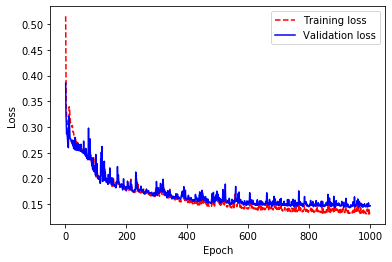

60/60 [==============================] - 1s 24ms/step
[0.17963364894191425, 0.8081868489583334]


In [145]:
#with weight decay all over
from keras.regularizers import l2
modelw = Sequential()
modelw.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(Activation('relu'))
modelw.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(MaxPooling2D(pool_size=(2,2)))
modelw.add(Activation('relu'))
modelw.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(MaxPooling2D(pool_size=(2,2)))
modelw.add(Activation('relu'))
modelw.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(Activation('relu'))
modelw.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None, kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(Activation('relu'))
modelw.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', output_padding=None, kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(Activation('relu'))
modelw.add(Conv2D(1, (1,1), padding='same', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
modelw.add(Activation('sigmoid'))

modelw.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])

histw = modelw.fit(x_tren, y_tren, epochs=1000, batch_size=minibatch, validation_data=(x_valid, y_valid))

plot_history(histw.history)
eval0w = modelw.evaluate(x_test, y_test_expanded, batch_size=1)
print(eval0w)

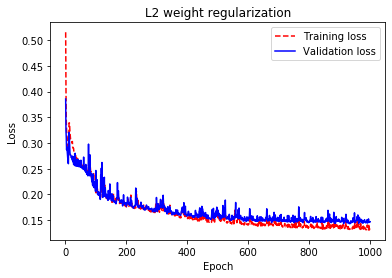

In [153]:
plot_history(histw.history, title="L2 weight regularization")

In [146]:
evaltw = modelw.evaluate(x_valid, y_valid, batch_size=1)
print(evaltw)

17/17 [==============================] - 0s 24ms/step
[0.1516023238792139, 0.8300637637867647]


Train on 68 samples, validate on 17 samples
Epoch 1/1000
68/68 [==============================] - 9s 131ms/step - loss: 0.3310 - acc: 0.4969 - val_loss: 0.2688 - val_acc: 0.5384
Epoch 2/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.2952 - acc: 0.4932 - val_loss: 0.2615 - val_acc: 0.5384
Epoch 3/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.2897 - acc: 0.4932 - val_loss: 0.2763 - val_acc: 0.5384
Epoch 4/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.2865 - acc: 0.4932 - val_loss: 0.2582 - val_acc: 0.5384
Epoch 5/1000
68/68 [==============================] - 5s 78ms/step - loss: 0.2827 - acc: 0.4932 - val_loss: 0.2558 - val_acc: 0.5384
Epoch 6/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.2827 - acc: 0.4932 - val_loss: 0.2803 - val_acc: 0.5384
Epoch 7/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.2864 - acc: 0.4932 - val_loss: 0.2506 - val_acc: 0.5384
Epoch 8/1000
68/68 [====

Epoch 62/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.1386 - acc: 0.8225 - val_loss: 0.1421 - val_acc: 0.8095
Epoch 63/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1328 - acc: 0.8356 - val_loss: 0.1595 - val_acc: 0.7905
Epoch 64/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1407 - acc: 0.8293 - val_loss: 0.1509 - val_acc: 0.7711
Epoch 65/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1468 - acc: 0.8013 - val_loss: 0.1679 - val_acc: 0.7911
Epoch 66/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1396 - acc: 0.8350 - val_loss: 0.1438 - val_acc: 0.8071
Epoch 67/1000
68/68 [==============================] - 5s 81ms/step - loss: 0.1384 - acc: 0.8358 - val_loss: 0.1419 - val_acc: 0.8016
Epoch 68/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1332 - acc: 0.8303 - val_loss: 0.1676 - val_acc: 0.7937
Epoch 69/1000
68/68 [==============================] - 5s 80ms

Epoch 123/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0987 - acc: 0.8751 - val_loss: 0.1202 - val_acc: 0.8336
Epoch 124/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.0971 - acc: 0.8777 - val_loss: 0.1347 - val_acc: 0.7970
Epoch 125/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1175 - acc: 0.8411 - val_loss: 0.1257 - val_acc: 0.8292
Epoch 126/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.1042 - acc: 0.8723 - val_loss: 0.1154 - val_acc: 0.8358
Epoch 127/1000
68/68 [==============================] - 5s 79ms/step - loss: 0.1046 - acc: 0.8634 - val_loss: 0.1137 - val_acc: 0.8381
Epoch 128/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0975 - acc: 0.8793 - val_loss: 0.1254 - val_acc: 0.8359
Epoch 129/1000
68/68 [==============================] - 5s 80ms/step - loss: 0.0980 - acc: 0.8788 - val_loss: 0.1203 - val_acc: 0.8229
Epoch 130/1000
68/68 [==============================] -

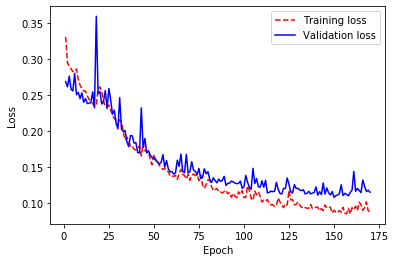

60/60 [==============================] - 1s 24ms/step
[0.16661593019962312, 0.8160146077473959]


In [147]:
# original, but early stopping
from keras.callbacks import EarlyStopping
modeles = Sequential()
modeles.add(Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 2)))
modeles.add(Activation('relu'))
modeles.add(Conv2D(64, (3,3), padding='same'))
modeles.add(MaxPooling2D(pool_size=(2,2)))
modeles.add(Activation('relu'))
modeles.add(Conv2D(128, (3,3), padding='same'))
modeles.add(MaxPooling2D(pool_size=(2,2)))
modeles.add(Activation('relu'))
modeles.add(Conv2D(128, (3,3), padding='same'))
modeles.add(Activation('relu'))
modeles.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', output_padding=None))
modeles.add(Activation('relu'))
modeles.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', output_padding=None))
modeles.add(Activation('relu'))
modeles.add(Conv2D(1, (1,1), padding='same'))
modeles.add(Activation('sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

modeles.compile(optimizer=adam,
              loss=dice_loss,
              metrics=['accuracy'])

histes = modeles.fit(x_tren, y_tren, epochs=1000, batch_size=minibatch, validation_data=(x_valid, y_valid), callbacks=[es])

plot_history(histes.history)
eval0es = modeles.evaluate(x_test, y_test_expanded, batch_size=1)
print(eval0es)

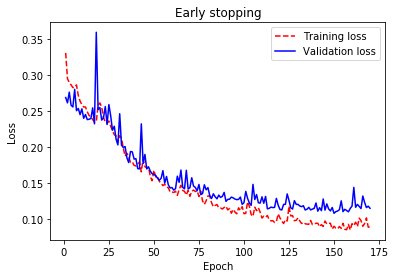

In [151]:
plot_history(histes.history, title="Early stopping")

In [148]:
evaltes = modeles.evaluate(x_valid, y_valid, batch_size=1)
print(evaltes)

17/17 [==============================] - 0s 25ms/step
[0.11794237178914688, 0.8394775390625]


In [ ]:
# a good old combo. 
#ALSO JUST BTW - vse zgorah so stvari za pomagat pri overfittingu... a bi mogogce mogla trenirat, ne vem, 300 epoch? da bi bla ziher da overfitas? pol makes more sense da regulariziras....al kaj
#evo, uporabi zgolj batchnorm + early stopping: 1000epochs. 

